# Tutorial: Calculating Scalar Quasinormal Modes of RN-AdS Black Holes

This tutorial demonstrates how to calculate scalar quasinormal modes (QNMs) of a Reissner-Nordström-Anti-de Sitter (RN-AdS) black hole using the ultraspherical spectral method. We'll go through this step-by-step, explaining the physics and numerical methods involved.

## Background Physics

The RN-AdS black hole is a charged, spherically symmetric solution to Einstein's equations with a negative cosmological constant. Its metric is given by:

$$ds^2 = f(r)dt^2 - \frac{dr^2}{f(r)} - r^2(d\theta^2 + \sin^2\theta d\phi^2),$$ 

where $f(r) = \Delta/r^2$ and $\Delta = r^2 - 2Mr + Q^2 + r^4/R^2$. The parameters are:
- $M$: black hole mass
- $Q$: black hole charge
- $R$: AdS radius (sets the cosmological constant scale)

## Method Overview

We'll use the ultraspherical spectral method to solve this problem. The key steps are:
1. Transform the wave equation to a more suitable form
2. Compactify the radial coordinate
3. Convert to a generalized eigenvalue problem
4. Solve using ultraspherical spectral methods

## References

For deeper understanding, consult these papers:
- [[gr-qc/0301052]](https://arxiv.org/abs/gr-qc/0301052): Comprehensive study of RN-AdS QNMs
- [[2209.09324]](https://arxiv.org/abs/2209.09324): Continued fraction method for SAdS QNMs
- [[hep-th/0003295]](https://arxiv.org/abs/hep-th/0003295): Early work on RN-AdS QNMs
- [[1202.1347]](https://arxiv.org/abs/1202.1347): Details on the spectral method

In [1]:
using ApproxFun, LinearAlgebra, Markdown, Plots

## Numerical Precision

We use `Float64` (double precision) by default for high accuracy results. For even higher precision calculations:
- Use `Double64` from the `DoubleFloats.jl` package
- Use `BigFloat` for arbitrary precision
- Other specialized numeric types are available

Note: Higher precision comes at the cost of computational speed.

In [2]:
TF = Float64

if TF != Float64
    # add eigvals! support for Complex{Double64} or Complex{BigFloat} matrices matrices
    using GenericSchur

    function LinearAlgebra.eigvals!(A::Matrix{Complex{TF}}, B::Matrix{Complex{TF}}; sortby::Function=abs)
        S = GenericSchur.ggschur!(A, B)
        λ = S.values
        LinearAlgebra.sorteig!(λ, sortby)
        return λ
    end
end

## Black Hole Parameters

We work in units where the AdS radius $R = 1$. The black hole is characterized by three parameters:
1. Horizon radius $r_+$
2. Mass $M$
3. Charge $Q$

These parameters are not independent. The extremal charge $Q_{\text{ext}}$ (maximum allowed charge) is:

$$Q_{\text{ext}}^2 = r_{+}^2 \left(1 + \frac{3 r_{+}^2}{R^2}\right)$$

The mass is related to $r_+$ and $Q$ by:

$$M = \frac{1}{2}\left(r_+ + \frac{r_+^3}{R^2} + \frac{Q^2}{r_+}\right)$$

Physical black holes must satisfy $Q \leq Q_{\text{ext}}$.

In [3]:
# AdS Radius
R = one(TF)
# horizon radius
r₊ = parse(TF, "1.0")
# black hole charge
Q = parse(TF, "0.0")

M = (r₊ + r₊^3 / R^2 + Q^2 / r₊) / 2
Qext = r₊ * sqrt(1 + 3 * r₊^2 / R^2)

if Q < Qext
    Markdown.parse("Black Hole Parameters:\n\$R = $R,\\, r_+ = $r₊,\\, M = $M,\\, Q = $Q,\\, Q_\\text{ext} = $Qext,\\, Q / Q_\\text{ext} = $(Q / Qext)\$")
else
    # Q is out of range
    Markdown.parse("Black Hole Parameters: Q is out of range!\n\$R = $R,\\, r_+ = $r₊,\\, M = $M,\\, Q = $Q,\\, Q_\\text{ext} = $Qext,\\, Q / Q_\\text{ext} = $(Q / Qext)\$")
end

Black Hole Parameters: $R = 1.0,\, r_+ = 1.0,\, M = 1.0,\, Q = 0.0,\, Q_\text{ext} = 2.0,\, Q / Q_\text{ext} = 0.0$


## Wave Equation and Transformations

### 1. Original Wave Equation

The scalar perturbation $\psi$ satisfies:

$$\frac{d^2 \psi}{dr_*^2} + \left(\omega^2 - V\right)\psi = 0$$

with potential:

$$V = f(r)\left[\frac{l(l+1)}{r^2} + \frac{f'(r)}{r}\right]$$

Here, $l$ is the angular momentum number.

### 2. Boundary Conditions

Physical solutions must satisfy:

$$\psi(r) \approx \begin{cases}  
e^{-i\omega r_*} & \text{at horizon } (r \to r_+) \\  
0 & \text{at infinity } (r \to \infty)  
\end{cases}$$

### 3. Transformations

We make several transformations to get a numerically tractable problem:

a) Define smooth part $\phi(r)$:
   $$\psi(r) = e^{-i\omega r_*} \phi(r)$$

b) Introduce finite coefficient function $F$:
   $$F = \frac{\Delta}{r^4}$$

c) Compactify radial coordinate:
   $$x = 1 - \frac{r_+}{r}$$
   This maps $[r_+,\infty)$ to $[0,1]$

### 4. Final Eigenvalue Problem

The transformed equation becomes:

$$A \phi = \omega B \phi$$

where operators $A$ and $B$ are defined in the code below.

In [4]:
# Function to compute QNMs for given parameters
function compute_qnms(l::Integer, n::Integer, r₊::TF, Q::TF)
    # domain x ∈ [0, 1]
    dom = zero(TF) .. one(TF)
    
    chebSpace = Chebyshev(dom)
    D = Derivative(chebSpace)
    conversion1to2 = Conversion(Ultraspherical(1, dom), Ultraspherical(2, dom))
    
    x = Fun(chebSpace)
    F = (r₊ * (r₊^3 / R^2 + r₊ * (x - 1)^2 + 2 * M * (x - 1)^3) + Q^2 * (x - 1)^4) / r₊^4
    dF = F'
    
    # Construct matrices
    cA2 = (x - 1)^2 * F
    cA1 = (x - 1)^2 * dF
    Vtilde = 2 * F + (x - 1) * (l * (l + 1) * (x - 1) / r₊^2 - dF)
    
    A = cA2 * D^2 + cA1 * D - Vtilde
    Am = @view(A[1:n, 1:n]) |> Matrix |> complex
    
    cB1 = 2im * (x - 1)^2 / r₊
    B = conversion1to2 * (cB1 * D)
    Bm = @view(B[1:n, 1:n]) |> Matrix
    
    # Boundary conditions
    Am[end, :] .= 1
    Bm[end, :] .= 0
    
    # Solve
    eigs = eigvals!(Am, Bm; sortby=abs)
    return filter(x -> !isnan(x) && imag(x) < 0, eigs)
end

compute_qnms (generic function with 1 method)

## Convergence Analysis

To ensure our results are reliable, we should check convergence by:
1. Computing QNMs at different spectral resolutions (n)
2. Comparing the values of lowest modes
3. Checking relative differences between successive resolutions

The method has converged when:
- QNM frequencies stabilize to desired precision
- Relative differences between successive resolutions become small

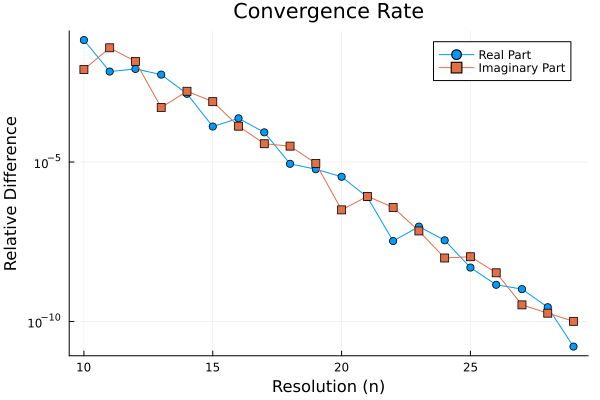

In [6]:
# Compute QNMs for different resolutions to test convergence
l = 0
resolutions = range(10, 30)
qnm_results = [compute_qnms(l, n, r₊, Q) for n in resolutions]

# Get first few modes for each resolution
first_modes = [qnms[1] for qnms in qnm_results]

# make real part to be positive
for i in 1:length(first_modes)
    if real(first_modes[i]) < 0
        first_modes[i] = Complex{TF}(-real(first_modes[i]), imag(first_modes[i]))
    end
end

# Plot relative differences between successive resolutions
rel_diffs_real = [abs((real(first_modes[i+1][1]) - real(first_modes[i][1])) / real(first_modes[i][1])) 
                  for i in 1:length(first_modes)-1]
rel_diffs_imag = [abs((imag(first_modes[i+1][1]) - imag(first_modes[i][1])) / imag(first_modes[i][1])) 
                  for i in 1:length(first_modes)-1]

p = plot(resolutions[1:end-1], rel_diffs_real,
    yscale=:log10, label="Real Part", marker=:circle,
    xlabel="Resolution (n)", ylabel="Relative Difference",
    title="Convergence Rate")
plot!(p, resolutions[1:end-1], rel_diffs_imag,
    label="Imaginary Part", marker=:square)

# Important Notes

1. This is a tutorial implementation - verify results against published literature
2. Test convergence for your specific parameters
3. Higher precision might be needed for:
   - Nearly extremal black holes (Q ≈ $Q_{\text{ext}}$)
   - High overtone numbers
   - Large angular numbers $\ell$